# &#x1F4D1; &nbsp;  Digit Recognition Models

## Style, Links and Libraries
[`R interface to Keras`](https://tensorflow.rstudio.com/keras/)

[`Package "keras"`](https://cran.r-project.org/web/packages/keras/keras.pdf)

[`Deep Learning with R. François Chollet, J.J. Allaire`](https://github.com/jjallaire/deep-learning-with-r-notebooks)

In [2]:
library(IRdisplay)
library(repr)
library(tensorflow)
library(keras)
library(imager)
library(R6)

In [3]:
display_html("<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #818286; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;} 
</style>")

## Dataset

In [35]:
df_train <- read.csv("kaggle_digits_train.csv")
df_test  <- read.csv("kaggle_digits_test.csv")

In [36]:
n <- nrow(df_train)
df_train <- df_train[sample(n),]

In [37]:
train_labels <- keras::to_categorical(as.matrix(df_train[,1]), num_classes=10)
train_images <- as.matrix(df_train[,-1]) / 255
test_images <- as.matrix(df_test) / 255
dim(train_images); dim(test_images); dim(train_labels)

[1] 42000   784

[1] 28000   784

[1] 42000    10

In [38]:
train_images[15:20,15:20]

,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19
34352,0,0,0,0,0,0
11161,0,0,0,0,0,0
17775,0,0,0,0,0,0
18328,0,0,0,0,0,0
31204,0,0,0,0,0,0
32103,0,0,0,0,0,0


[1] 28 28

[1] 1 0 0 0 0 0 0 0 0 0

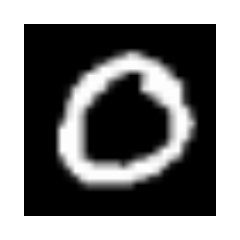

In [42]:
options(repr.plot.width=2,repr.plot.height=2)
par(mar=c(1,1,1,1))
image_example <- train_images[1000,]
image_example <- array_reshape(image_example,c(28,28))
dim(image_example)
train_labels[1000,]
plot(as.raster(image_example))

In [40]:
train_indices <- 1:round(0.6 * n)
valid_indices <- (round(0.6 * n) + 1):round(0.8 * n)
test_indices <- (round(0.8 * n) + 1):n

In [43]:
x_train <- train_images[train_indices,]
y_train <- train_labels[train_indices,]
x_valid <- train_images[valid_indices,]
y_valid <- train_labels[valid_indices,]
x_test <- train_images[test_indices,]
y_test <- train_labels[test_indices,]

In [45]:
dim(x_train); dim(x_valid); dim(x_test); dim(y_train); dim(y_valid); dim(y_test)

[1] 25200   784

[1] 8400  784

[1] 8400  784

[1] 25200    10

[1] 8400   10

[1] 8400   10

## Neural Network Models

In [71]:
# CNN
cnn_model <- keras_model_sequential()

cnn_model %>% 
  
layer_conv_2d(input_shape=c(28,28,1),
              filter=28,kernel_size=c(5,5),padding="same") %>%  
layer_activation_leaky_relu(alpha=0.02) %>%  
  
layer_max_pooling_2d(pool_size=c(2,2)) %>%  
layer_dropout(0.25) %>%

layer_conv_2d(filter=128,kernel_size=c(5,5),padding="same") %>% 
layer_activation_leaky_relu(alpha=0.02) %>%  

layer_max_pooling_2d(strides=c(2,2)) %>%  
layer_dropout(0.25) %>%

layer_global_max_pooling_2d() %>%  

layer_dense(1024) %>%  
layer_activation_leaky_relu(alpha=0.02) %>% 
layer_dropout(0.5) %>%  
  
layer_dense(10) %>%    
layer_activation("softmax")

In [72]:
cnn_model %>%
  compile(loss="categorical_crossentropy",optimizer="nadam",metrics="accuracy")

In [73]:
summary(cnn_model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_8 (Conv2D)                   (None, 28, 28, 28)              728         
________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)           (None, 28, 28, 28)              0           
________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)      (None, 14, 14, 28)              0           
________________________________________________________________________________
dropout_10 (Dropout)                (None, 14, 14, 28)              0           
________________________________________________________________________________
conv2d_9 (Conv2D)                   (None, 14, 14, 128)             89728       
________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)   

In [75]:
cnn_fit <- cnn_model %>%
  fit(x=array_reshape(x_train,c(dim(x_train)[1],28,28,1)),
      y=y_train,
      validation_data=list(array_reshape(x_valid,c(dim(x_valid)[1],28,28,1)),y_valid),
      shuffle=T,
      batch_size=128,
      epochs=50,
      callbacks=list(callback_model_checkpoint("cnn_best_digits.h5",save_best_only=T),
                     callback_reduce_lr_on_plateau(monitor="val_loss",factor=0.05)))

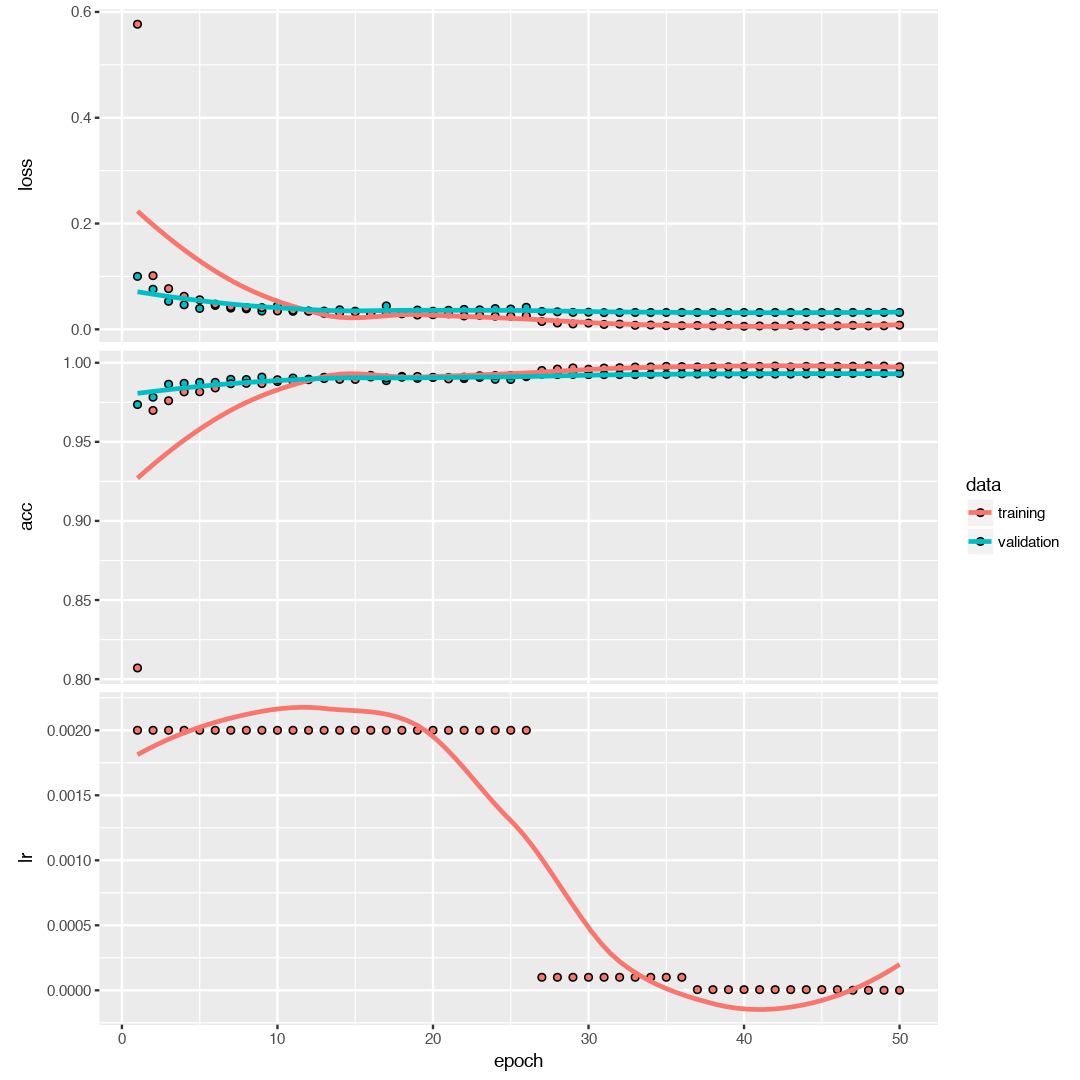

In [87]:
options(warn=-1,repr.plot.width=9,repr.plot.height=9)
plot(cnn_fit)

In [88]:
cnn_fit_df <- as.data.frame(cnn_fit)
cnn_fit_df[81:100,]

,epoch,value,metric,data
81,31,0.9925000,acc,validation
82,32,0.9925000,acc,validation
83,33,0.9925000,acc,validation
84,34,0.9926190,acc,validation
85,35,0.9926190,acc,validation
86,36,0.9929762,acc,validation
87,37,0.9928571,acc,validation
88,38,0.9928571,acc,validation
89,39,0.9928571,acc,validation
90,40,0.9927381,acc,validation


In [83]:
load_model_weights_hdf5(cnn_model,"cnn_best_digits.h5")

In [84]:
cnn_score <- cnn_model %>% 
    evaluate(array_reshape(x_test,c(dim(x_test)[1],28,28,1)),y_test)
cnn_score

$loss
[1] 0.02482229

$acc
[1] 0.992619

In [90]:
generated_images <- image_data_generator(zoom_range=0.2, shear_range=0.2, rotation_range=20)
generated_images %>% 
    fit_image_data_generator(array_reshape(x_train,c(dim(x_train)[1],28,28,1)))

In [91]:
dg_cnn_fit <- cnn_model %>%
    fit_generator(flow_images_from_data(array_reshape(x_train,c(dim(x_train)[1],28,28,1)),
                                        y_train,
                                        generated_images,
                                        batch_size=128), 
                  steps_per_epoch=1000, 
                  epochs=50,
                  validation_data=list(array_reshape(x_valid,c(dim(x_valid)[1],28,28,1)),y_valid),
                  callbacks=list(callback_model_checkpoint("cnn_best_digits.h5",save_best_only=T),
                                 callback_reduce_lr_on_plateau(monitor="val_loss",factor=0.05)))

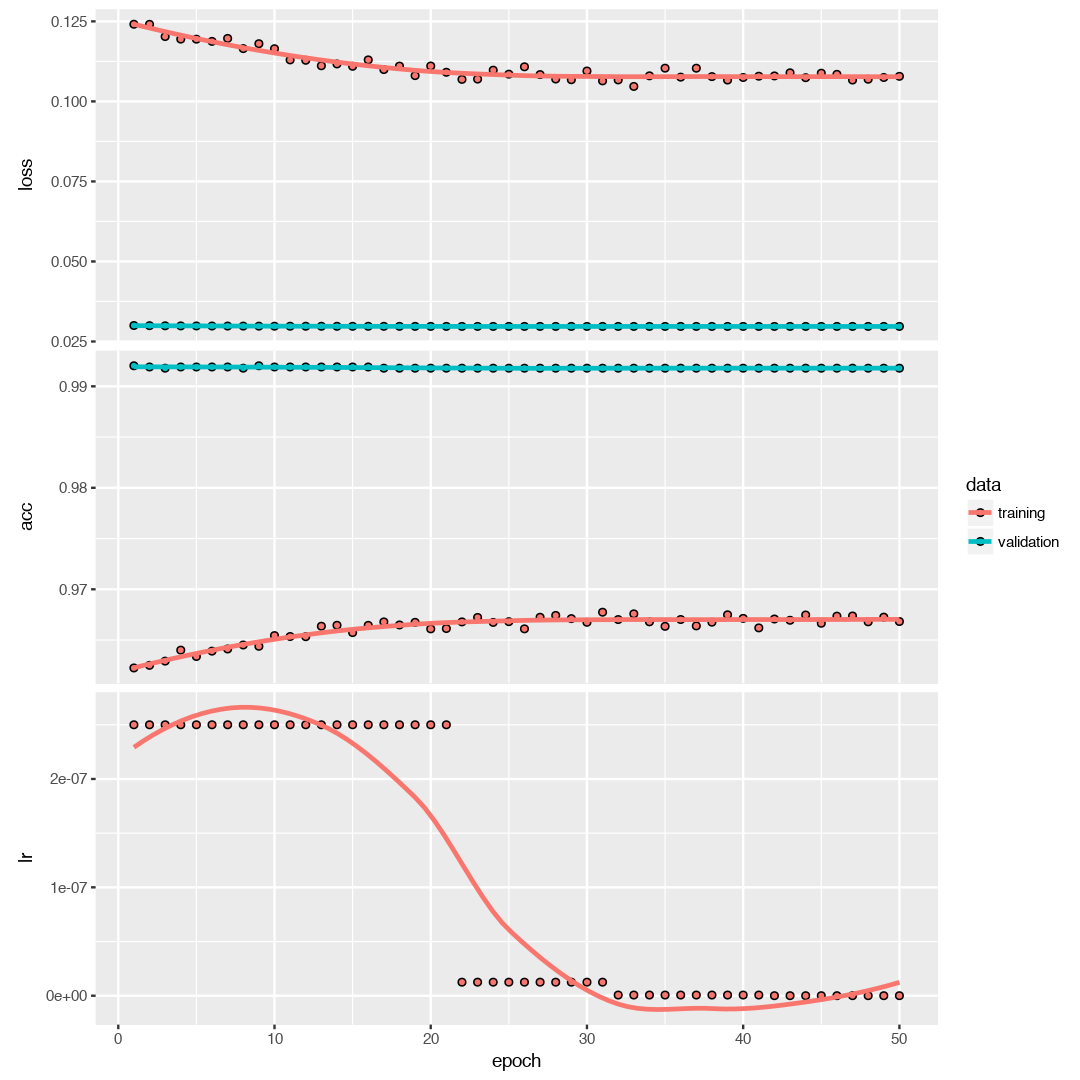

In [93]:
options(warn=-1,repr.plot.width=9,repr.plot.height=9)
plot(dg_cnn_fit)

In [94]:
load_model_weights_hdf5(cnn_model,"cnn_best_digits.h5")

In [95]:
dg_cnn_score <- cnn_model %>% 
    evaluate(array_reshape(x_test,c(dim(x_test)[1],28,28,1)),y_test)
dg_cnn_score

$loss
[1] 0.02550636

$acc
[1] 0.9925

In [96]:
# MLP
mlp_model <- keras_model_sequential()

mlp_model %>%  

layer_dense(1568, input_shape=c(784)) %>%  
layer_activation("relu") %>%  
layer_dropout(0.2) %>% 

layer_dense(392) %>%  
layer_activation("relu") %>%  
layer_dropout(0.2) %>%

layer_dense(128) %>%  
layer_activation("relu") %>%  
layer_dropout(0.2) %>%
  
layer_dense(10) %>%    
layer_activation("softmax")

In [97]:
mlp_model %>%
  compile(loss="categorical_crossentropy",optimizer="nadam",metrics="accuracy")

In [98]:
summary(mlp_model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_9 (Dense)                     (None, 1568)                    1230880     
________________________________________________________________________________
activation_9 (Activation)           (None, 1568)                    0           
________________________________________________________________________________
dropout_13 (Dropout)                (None, 1568)                    0           
________________________________________________________________________________
dense_10 (Dense)                    (None, 392)                     615048      
________________________________________________________________________________
activation_10 (Activation)          (None, 392)                     0           
________________________________________________________________________________
dropout_14 (Dropout)        

In [99]:
mlp_fit <- mlp_model %>%
  fit(x=x_train,
      y=y_train,
      validation_data=list(x_valid,y_valid),
      shuffle=T,
      batch_size=128,
      epochs=50,
      callbacks=list(callback_model_checkpoint("mlp_best_digits.h5",save_best_only=T),
                     callback_reduce_lr_on_plateau(monitor="val_loss",factor=0.05)))

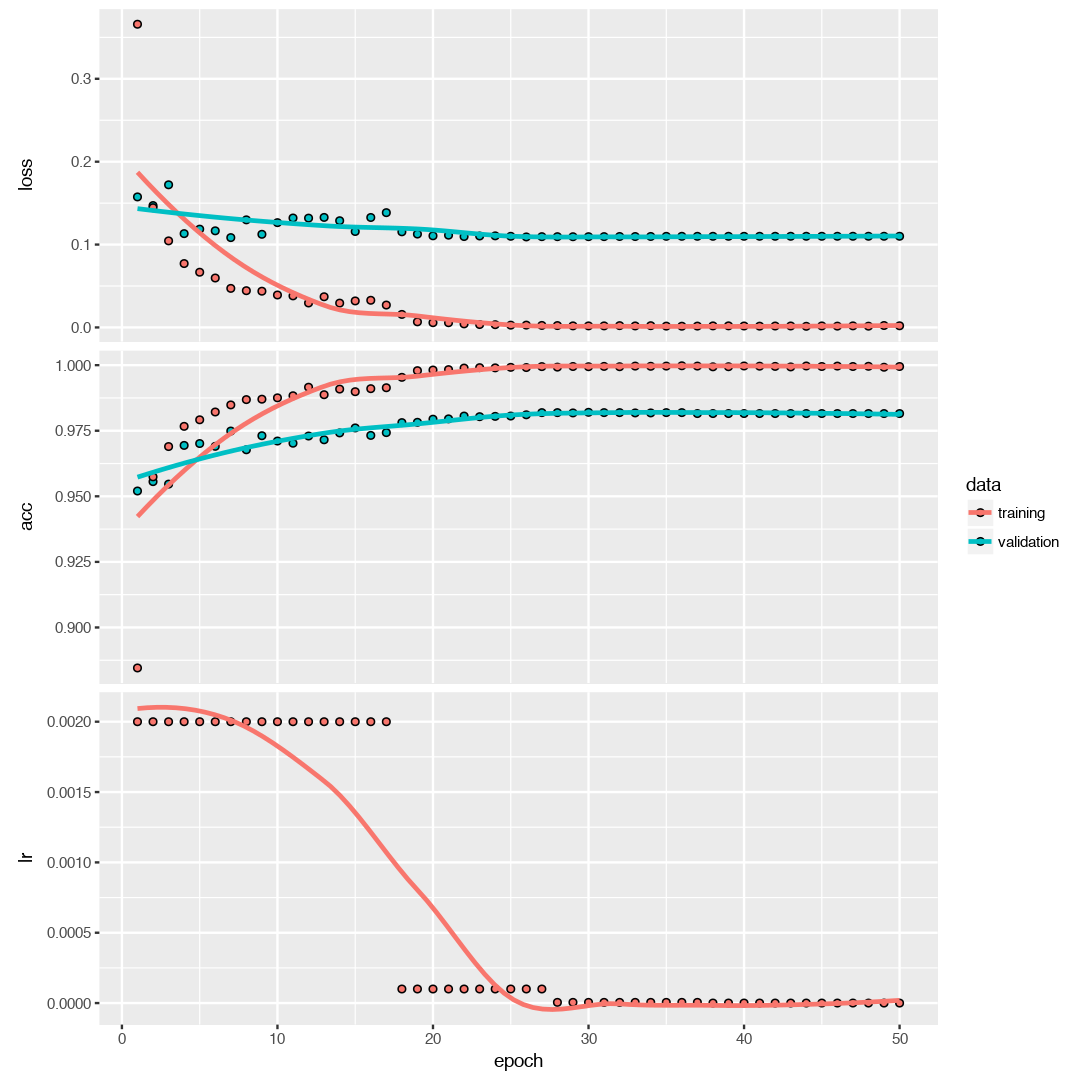

In [100]:
options(warn=-1,repr.plot.width=9,repr.plot.height=9)
plot(mlp_fit)

In [101]:
mlp_fit_df <- as.data.frame(mlp_fit)
mlp_fit_df[81:100,]

,epoch,value,metric,data
81,31,0.9819048,acc,validation
82,32,0.9819048,acc,validation
83,33,0.9817857,acc,validation
84,34,0.9817857,acc,validation
85,35,0.9819048,acc,validation
86,36,0.9819048,acc,validation
87,37,0.9815476,acc,validation
88,38,0.9815476,acc,validation
89,39,0.9815476,acc,validation
90,40,0.9815476,acc,validation


In [102]:
load_model_weights_hdf5(mlp_model,"mlp_best_digits.h5")

In [103]:
mlp_score <- mlp_model %>% 
    evaluate(x_test,y_test)
mlp_score

$loss
[1] 0.09521187

$acc
[1] 0.9765476